In [1]:
import os
# from hanziconv import HanziConv # trash
lab_lst = []
wav_lst = []
lab_dirPath = "./labels/mono/"
wav_dirPath = "./wav/"

for dirPath, dirNames, fileNames in os.walk(lab_dirPath):
    for f in fileNames:
        lab_lst.append(os.path.join(dirPath, f))
for dirPath, dirNames, fileNames in os.walk(wav_dirPath):
    for f in fileNames:
        wav_lst.append(os.path.join(dirPath, f))
print(lab_lst[:3])
print(wav_lst[:3])

['./labels/mono/nitech_jp_song070_f001_003.lab', './labels/mono/nitech_jp_song070_f001_004.lab', './labels/mono/nitech_jp_song070_f001_007.lab']
['./wav/nitech_jp_song070_f001_003.wav', './wav/nitech_jp_song070_f001_004.wav', './wav/nitech_jp_song070_f001_007.wav']


# Extract all label

In [98]:
import soundfile as sf
import copy as cp
song_id = 0
fs = 44100

#pitch will change!
# x,_ = sf.read(wav_lst[song_id])
# x = librosa.resample(x, fs, 44100)

x,_ = sf.read('nagoya_003_44100.wav')


with open(lab_lst[song_id],'r') as f:
    lab_ori = f.read().split('\n')
    lab = cp.copy(lab_ori)[:-1]

for i in range(len(lab_ori)-1):
    lab[i] = lab_ori[i].split(' ')
    lab[i][0] = int(int(lab[i][0])/10000000*fs)
    lab[i][1] = int(int(lab[i][1])/10000000*fs)
    print(lab[i])
ipd.Audio(x, rate=fs)


[0, 52038, 'pau']
[52038, 54022, 'd']
[54022, 72103, 'e']
[72103, 78498, 'N']
[78498, 80923, 'd']
[80923, 92389, 'e']
[92389, 99665, 'N']
[99665, 105619, 'm']
[105619, 119952, 'u']
[119952, 124582, 'sh']
[124582, 127669, 'i']
[127669, 130756, 'm']
[130756, 140238, 'u']
[140238, 145530, 'sh']
[145530, 155011, 'i']
[155011, 158539, 'k']
[158539, 174195, 'a']
[174195, 177723, 't']
[177723, 181692, 'a']
[181692, 185661, 'ts']
[185661, 195804, 'u']
[195804, 199552, 'm']
[199552, 209695, 'u']
[209695, 211680, 'r']
[211680, 241227, 'i']
[241227, 261733, 'pau']
[261733, 281358, 'o']
[281358, 283563, 'm']
[283563, 290619, 'a']
[290619, 302305, 'e']
[302305, 305833, 'n']
[305833, 317740, 'o']
[317740, 334939, 'a']
[334939, 338688, 't']
[338688, 343318, 'a']
[343318, 345964, 'm']
[345964, 355446, 'a']
[355446, 359194, 'w']
[359194, 369337, 'a']
[369337, 371983, 'd']
[371983, 387418, 'o']
[387418, 390505, 'k']
[390505, 395577, 'o']
[395577, 397782, 'n']
[397782, 410791, 'i']
[410791, 422037, 'a']


In [100]:
x_seg = cp.copy(x[:44100*6])
aiueo = ['a','i','u','e','o'] 
for ll in lab:
    head,tail,v = ll
    if tail>len(x_seg):
        break
    if v in aiueo:
        x_seg[head:tail] = 0
        
    

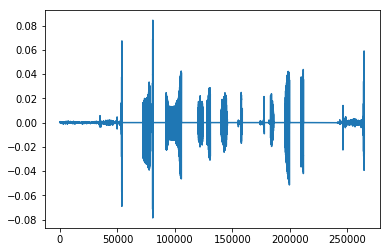

In [101]:
import IPython.display as ipd
import matplotlib.pyplot as plt
plt.plot(x_seg)
ipd.Audio(x_seg, rate=fs)

In [161]:
import scipy
import librosa
import numpy as np
import soundfile  as sf
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm_notebook as tqdm

frame_period = 10
_NFFT_ = 8192
HOP_LEN = int(fs/(1000/frame_period)) #480
def griffin_lim(stftm_matrix, shape, min_iter=20, max_iter=50, delta=20):
    y = np.random.random(shape)
    y_iter = []

    for i in tqdm(range(max_iter)):
        if i >= min_iter and (i - min_iter) % delta == 0:
            y_iter.append((y, i))
        stft_matrix = librosa.core.stft(y,n_fft=_NFFT_,win_length = 8192, hop_length=HOP_LEN)
        stft_matrix = stftm_matrix * stft_matrix / np.abs(stft_matrix)
        y = librosa.core.istft(stft_matrix,hop_length=HOP_LEN)
    return y


(601,)


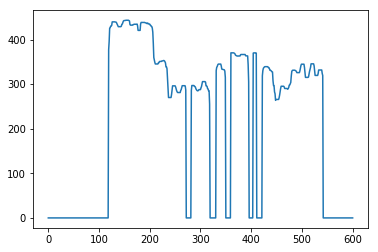

In [103]:
import pyworld as pw

x_seg = cp.copy(x[:44100*6])

f0, t = pw.dio(x_seg, fs,frame_period=frame_period)
f0 = scipy.signal.medfilt(f0,11)
plt.plot(f0)
print(f0.shape)

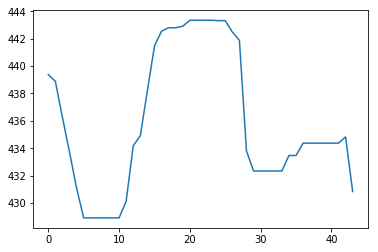

In [104]:
# 58800, 78480
head = 58800
tail = 78480
head_n = int(head/fs*1000/frame_period)
tail_n = int(tail/fs*1000/frame_period)
plt.plot(f0[head_n:tail_n])

# build spectrum table

a.wav


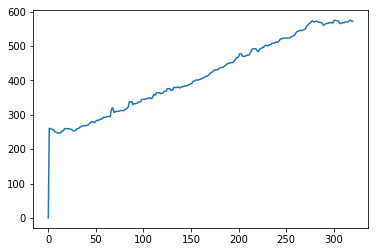

(321,) (4097, 321)


In [105]:
for dirPath, dirNames, fileNames in os.walk('./gliss_mono/iton'):
    for f in fileNames:
        print(f)
        x,fs = sf.read('./gliss_mono/iton/'+f)
        f0, t = pw.dio(x, fs,frame_period=frame_period)
        sp = librosa.core.stft(x,n_fft=_NFFT_,win_length = 8192, hop_length=int(fs/1000*frame_period))
        f0 = scipy.signal.medfilt(f0,3)
        plt.plot(f0)
        plt.show()
        print(f0.shape,sp.shape)
        break

# dic:
    :--singer_id  
    : |--vowel
    :    |--pitch->{sp,ap}
pitch: quantized 0.25 note

In [119]:
import pickle
with open('./dic/d.pkl', 'rb') as f:
    dic = pickle.load(f)
min_n,max_n = dic[0]['pRange']

In [107]:
def note2f0(n):
    return 440.0*np.power(2,(n-49)/12.0)
def f02note(f):
    return np.log2(f/440.0)*12+49
f = note2f0(60)
n = f02note(f)
print(n)


60.0


In [108]:
f0_trim =  f0[~(f0 <= 0.1)]  
n = f02note(f0_trim)
print(max(n),min(n))

53.63020575516094 38.9930089829548


In [109]:
n_clip = np.clip(n- (n%0.25),min_n,max_n)
sps = []

# WORLD synth

In [122]:
f0, sp, ap = pw.wav2world(x_seg, fs, frame_period =  frame_period) 
f0 = scipy.signal.medfilt(f0,5)
n = f02note(f0)
n_clip = np.clip(n- (n%0.25),min_n,max_n)

C:\Users\a1989\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
C:\Users\a1989\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in remainder
  after removing the cwd from sys.path.


In [123]:
def samp2frame(x,fs,frame_period):
    return int(x/(fs/(1000/frame_period)))
samp2frame(tail,fs,frame_period)

177

In [124]:
_sp = cp.copy(sp)
_ap = cp.copy(ap)

for l in lab:
    print(l)
    if l[2] in ['a','i','u','e','o']:
        f1 = samp2frame(l[0],fs,frame_period)
        f2 = samp2frame(l[1],fs,frame_period)
        for i in range(f1,f2):
            try:
                _sp[i] = dic[0][l[2]][n_clip[i]]['sp']
                _ap[i] = dic[0][l[2]][n_clip[i]]['ap']
            except:pass
    if l[1]>44100*6:
        break

[0, 52038, 'pau']
[52038, 54022, 'd']
[54022, 72103, 'e']
[72103, 78498, 'N']
[78498, 80923, 'd']
[80923, 92389, 'e']
[92389, 99665, 'N']
[99665, 105619, 'm']
[105619, 119952, 'u']
[119952, 124582, 'sh']
[124582, 127669, 'i']
[127669, 130756, 'm']
[130756, 140238, 'u']
[140238, 145530, 'sh']
[145530, 155011, 'i']
[155011, 158539, 'k']
[158539, 174195, 'a']
[174195, 177723, 't']
[177723, 181692, 'a']
[181692, 185661, 'ts']
[185661, 195804, 'u']
[195804, 199552, 'm']
[199552, 209695, 'u']
[209695, 211680, 'r']
[211680, 241227, 'i']
[241227, 261733, 'pau']
[261733, 281358, 'o']


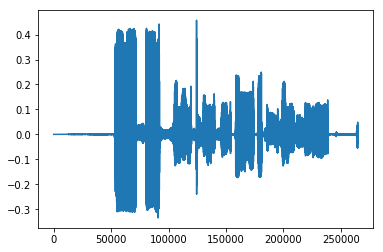

In [125]:
y = pw.synthesize(f0, _sp, _ap, fs, frame_period = frame_period)
plt.plot(y)

In [126]:
# sf.write('test.wav',y,fs)
ipd.Audio(y, rate=fs)

# synth by stft

In [162]:
import scipy
import librosa
import numpy as np
import soundfile  as sf
import matplotlib.pyplot as plt
import IPython.display as ipd

spec = librosa.core.stft(x_seg,n_fft=_NFFT_,win_length = 8192, hop_length=HOP_LEN)
_spec = cp.copy(spec)
abs_x = np.abs(sp)
print(sp.shape)
for l in lab:
    print(l)
    if l[2] in ['a','i','u','e','o']:
        f1 = samp2frame(l[0],fs,frame_period)
        f2 = samp2frame(l[1],fs,frame_period)
        for i in range(f1,f2):
            try:
                _spec[:,i] = dic[0][l[2]][n_clip[i]]['spec']
            except:pass
    if l[1]>44100*6:
        break


(601, 1025)
[0, 52038, 'pau']
[52038, 54022, 'd']
[54022, 72103, 'e']
[72103, 78498, 'N']
[78498, 80923, 'd']
[80923, 92389, 'e']
[92389, 99665, 'N']
[99665, 105619, 'm']
[105619, 119952, 'u']
[119952, 124582, 'sh']
[124582, 127669, 'i']
[127669, 130756, 'm']
[130756, 140238, 'u']
[140238, 145530, 'sh']
[145530, 155011, 'i']
[155011, 158539, 'k']
[158539, 174195, 'a']
[174195, 177723, 't']
[177723, 181692, 'a']
[181692, 185661, 'ts']
[185661, 195804, 'u']
[195804, 199552, 'm']
[199552, 209695, 'u']
[209695, 211680, 'r']
[211680, 241227, 'i']
[241227, 261733, 'pau']
[261733, 281358, 'o']


In [150]:
x_seg.shape

(264600,)

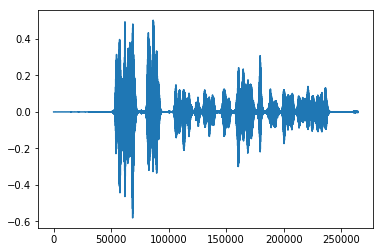

In [163]:
fs = 44100
y = griffin_lim(_spec, x_seg.shape)
plt.plot(y)
plt.show()
ipd.Audio(y, rate=fs)

In [132]:
_x_seg = cp.copy(x_seg)
for l in lab:
    print(l)
    if l[2] in ['a','i','u','e','o']:
        _x_seg[l[0]:l[1]] = 0
    if l[1]>44100*6:
        break

[0, 52038, 'pau']
[52038, 54022, 'd']
[54022, 72103, 'e']
[72103, 78498, 'N']
[78498, 80923, 'd']
[80923, 92389, 'e']
[92389, 99665, 'N']
[99665, 105619, 'm']
[105619, 119952, 'u']
[119952, 124582, 'sh']
[124582, 127669, 'i']
[127669, 130756, 'm']
[130756, 140238, 'u']
[140238, 145530, 'sh']
[145530, 155011, 'i']
[155011, 158539, 'k']
[158539, 174195, 'a']
[174195, 177723, 't']
[177723, 181692, 'a']
[181692, 185661, 'ts']
[185661, 195804, 'u']
[195804, 199552, 'm']
[199552, 209695, 'u']
[209695, 211680, 'r']
[211680, 241227, 'i']
[241227, 261733, 'pau']
[261733, 281358, 'o']


In [133]:
ipd.Audio(_x_seg, rate=fs)

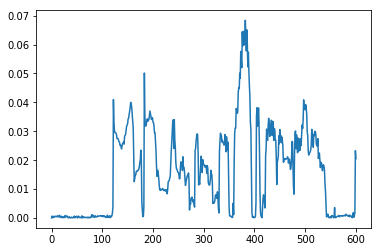

In [146]:
s =  librosa.feature.rmse(y=x_seg, S=None, frame_length=100, hop_length=HOP_LEN, center=True)
s.shape
plt.plot(s.flatten())

In [128]:
sf.write('test.wav',x_seg,fs)

In [138]:
ipd.Audio(_x_seg+y, rate=fs)
sf.write('test.wav',_x_seg+y,fs)